# Settings

In [2]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table
from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd

Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

# Data

In [3]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

# Compute Mean, SD, Residuals

In [4]:
def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    
    lnr_cut = np.array(
        [rich_model.get_cut(lnM[i], z[i]) for i in range(len(dt_halos))])

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
#     sigma_cut = 5.0

#     sigma_cut_array = np.abs(abs_err) < sigma_cut
#     print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

#     lnR_mean = lnR_mean[sigma_cut_array]
#     z_sigma_cut = z[sigma_cut_array]
#     lnM_sigma_cut = lnM[sigma_cut_array]
#     abs_err = abs_err[sigma_cut_array]
#     lnR_ext = lnR[sigma_cut_array]
#     lnr_cut = lnr_cut[sigma_cut_array] 
    
    lnR_mean = lnR_mean
    z_sigma_cut = z
    lnM_sigma_cut = lnM
    abs_err = abs_err
    lnR_ext = lnR
    lnr_cut = lnr_cut
    
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnr_cut, lnR_ext 


# Bins

In [5]:
# redshift bins
z_0 = 0.0
z_1 = 0.1
halos_bin_z =[]

for i in range(30):
    cut_z = np.logical_and (dt_halos['redshift_true'] > z_0, dt_halos['redshift_true'] < z_1)
    halos_bin_z.append(dt_halos[cut_z])
    z_0 = z_0 + 0.1
    z_1 = z_1 + 0.1

# mass bins
label = []
halos_bin_mz =[]
for i in range(30):
    lnM_0 = min(lnM)
    lnM_1 = min(lnM) + 0.5

    for j in range(9):
        cut = np.logical_and (np.log(halos_bin_z[i]["m200c"]) > lnM_0, np.log(halos_bin_z[i]["m200c"]) < lnM_1)
        halos_bin_mz.append(halos_bin_z[i][cut])
        label.append(f"{min(halos_bin_z[i]['redshift_true']):.3f} < z < {max(halos_bin_z[i]['redshift_true']):.3f}\n{lnM_0:.3f} < lnM < {lnM_1:.3f}")
        lnM_0 = lnM_0 + 0.5
        lnM_1 = lnM_1 + 0.5

# Fitting - binned data

In [ ]:
fit_results_ascaso = []
fit_results_ext = []

mean_ext_list=[]

for i in range(len(halos_bin_mz)):
    
    if len(halos_bin_mz[i]) == 0:
        fit_results_ascaso.append(([], [], [], [], [] ,[]))
        fit_results_ext.append(([], [], [], [], [] ,[]))

    
    else:
        rmdata = create_richness_mass_calib(halos_bin_mz[i])

        use_ascaso = False

        ascaso = Nc.ClusterMassAscaso()

        ascaso.param_set_by_name("mup0", 4.45393539397061)
        # ascaso.param_set_by_name("mup1", 0.688627943224023)
        # ascaso.param_set_by_name("mup2", 1.23735536845047)
        # ascaso.param_set_by_name("sigmap0", 0.227197277810533)
        # ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
        # ascaso.param_set_by_name("sigmap2", -0.125446104089159)
        ascaso.param_set_by_name("cut", 1e15)
        
        ascaso.param_set_by_name("mup1", 0.0)
        ascaso.param_set_by_name("mup2", 0.0)
        ascaso.param_set_by_name("sigmap0", 0.227197277810533)
        ascaso.param_set_by_name("sigmap1", 0.0)
        ascaso.param_set_by_name("sigmap2", 0.0)


        ascaso.param_set_ftype(0, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(1, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(2, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(3, Ncm.ParamType.FREE)
        ascaso.param_set_ftype(4, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(5, Ncm.ParamType.FIXED)
        ascaso.param_set_ftype(6, Ncm.ParamType.FIXED)

        lnrich_ext = Nc.ClusterMassLnrichExt()
        lnrich_ext.param_set_by_name("mu", 4.60456407051582)
        # lnrich_ext.param_set_by_name("muM1", 0.872079943089853)
        # lnrich_ext.param_set_by_name("muZ1", 1.77432682440775)
        # lnrich_ext.param_set_by_name("muM2", 0.0417736274804596)
        # lnrich_ext.param_set_by_name("muZ2", -0.140721577418961)
        # lnrich_ext.param_set_by_name("muMZ", 0.142254333837774)
        
        lnrich_ext.param_set_by_name("muM1", 0.0)
        lnrich_ext.param_set_by_name("muZ1", 0.0)
        lnrich_ext.param_set_by_name("muM2", 0.0)
        lnrich_ext.param_set_by_name("muZ2", 0.0)
        lnrich_ext.param_set_by_name("muMZ", 0.0)
        
        lnrich_ext.param_set_by_name("sigma0", 0.288099083637692)
#         lnrich_ext.param_set_by_name("sigmaM1", 0.01665425603827)
#         lnrich_ext.param_set_by_name("sigmaZ1", -0.0170544925340452)
#         lnrich_ext.param_set_by_name("sigmaM2", 0.0151710348889877)
#         lnrich_ext.param_set_by_name("sigmaZ2", 0.00841242091702829)
#         lnrich_ext.param_set_by_name("sigmaMZ", 0.0375086602261856)
        
        lnrich_ext.param_set_by_name("sigmaM1", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ1", 0.0)
        lnrich_ext.param_set_by_name("sigmaM2", 0.0)
        lnrich_ext.param_set_by_name("sigmaZ2", 0.0)
        lnrich_ext.param_set_by_name("sigmaMZ", 0.0)


        lnrich_ext.param_set_by_name("cut", 1e15)
        lnrich_ext.param_set_by_name("cutM1", 0)
        lnrich_ext.param_set_by_name("cutZ1", 0)


        lnrich_ext.param_set_ftype(0, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(1, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(2, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(3, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(4, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(5, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(6, Ncm.ParamType.FREE)

        lnrich_ext.param_set_ftype(7, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(8, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(9, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(10, Ncm.ParamType.FREE)
        lnrich_ext.param_set_ftype(11, Ncm.ParamType.FREE)

        lnrich_ext.param_set_ftype(12, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(13, Ncm.ParamType.FIXED)
        lnrich_ext.param_set_ftype(14, Ncm.ParamType.FIXED)

        mset_ascaso = Ncm.MSet()
        mset_ascaso.set(ascaso)

        mset_ext = Ncm.MSet()
        mset_ext.set(lnrich_ext)

        dset = Ncm.Dataset.new()
        dset.append_data(rmdata)

        lh = Ncm.Likelihood.new(dset)

        # mset_ascaso.param_set_all_ftype(Ncm.ParamType.FIXED)
        # mset_ext.param_set_all_ftype(Ncm.ParamType.FIXED)

        fit_ascaso = Ncm.Fit.factory(
            Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ascaso, Ncm.FitGradType.NUMDIFF_CENTRAL)

        fit_ext = Ncm.Fit.factory(
            Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_ext, Ncm.FitGradType.NUMDIFF_CENTRAL)

        fit_ascaso.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        fit_ext.run_restart(Ncm.FitRunMsgs.SIMPLE, 1.0e-3, 0.0, None, None)
        
        
        dt_halos = halos_bin_mz[i]
        lnM = np.log(dt_halos["m200c"])  # ln(mass)
        z = dt_halos["redshift_true"]  # redshift
        lnR = np.log(dt_halos["richness"])  # ln(richness)

        res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso  = compute_res(ascaso)

        res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext  = compute_res(lnrich_ext)

        fit_results_ascaso.append((res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnr_cut_ascaso, lnR_ascaso))
        fit_results_ext.append((res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnr_cut_ext, lnR_ext))
        mean_ext_list.append(lnR_mean_ext)


# Residuals results

In [ ]:
#Resíduos binnados: Ascaso

#lnM 

fig = plt.figure(figsize=(20,150))
plt.subplots_adjust(wspace=0.5, 
                    hspace=1.5)


for i in range(len(fit_results_ascaso)): 
    
        t=i+1

        axt = fig.add_subplot(70,5,t)


        axt.scatter(fit_results_ascaso[i][3], fit_results_ascaso[i][0], c="salmon")
        axt.set_xlabel("$\ln M$", fontsize=12)
        axt.set_ylabel("Resíduos:\nAscaso", fontsize=12)
        axt.set_title(label[i],fontsize=14)
    

##plt.savefig('Figures/Res_Ascaso_lnM_1.png', format='png')


# z 

fig = plt.figure(figsize=(20,150))
plt.subplots_adjust(wspace=0.5, 
                    hspace=1.5)


for i in range(len(fit_results_ascaso)): 
    
        t=i+1

        axt = fig.add_subplot(70,5,t)


        axt.scatter(fit_results_ascaso[i][2], fit_results_ascaso[i][0], c="salmon")
        axt.set_xlabel("$z$", fontsize=12)
        axt.set_ylabel("Resíduos:\nAscaso", fontsize=12)
        axt.set_title(label[i],fontsize=14)
    

#plt.savefig('Figures/Res_Ascaso_z_1.png', format='png')



In [ ]:
#Resíduos binnados: Ext

#lnM - Parte1

fig = plt.figure(figsize=(20,150))
plt.subplots_adjust(wspace=0.5, 
                    hspace=1.5)


for i in range(len(fit_results_ext)): 
    
        t=i+1

        axt = fig.add_subplot(70,5,t)


        axt.scatter(fit_results_ext[i][3], fit_results_ext[i][0], c="skyblue")
        axt.set_xlabel("$\ln M$", fontsize=12)
        axt.set_ylabel("Resíduos:\nExtended", fontsize=12)
        axt.set_title(label[i],fontsize=14)
    

#plt.savefig('Figures/Res_Extended_lnM_1.png', format='png')

# z

fig = plt.figure(figsize=(20,150))
plt.subplots_adjust(wspace=0.5, 
                    hspace=1.5)


for i in range(70): 
    
        t=i+1

        axt = fig.add_subplot(70,5,t)


        axt.scatter(fit_results_ext[i][2], fit_results_ext[i][0], c="skyblue")
        axt.set_xlabel("$z$", fontsize=12)
        axt.set_ylabel("Resíduos:\nExtended", fontsize=12)
        axt.set_title(label[i],fontsize=14)
    

#plt.savefig('Figures/Res_Extended_z_1.png', format='png')



In [ ]:
#Ext
res_ext_m = [i for i, j, k, l, m, n in fit_results_ext]
res_ascaso_m = [i for i, j, k, l, m, n in fit_results_ascaso]
    
fig, axs = plt.subplots(nrows=28, ncols=10,figsize=(23,50))


for res_ext, ax, i in zip(res_ext_m, axs.flat, range(len(res_ext_m))):
    
    points = np.linspace(stats.norm.ppf(0.01,loc=np.mean(res_ext),scale=np.std(res_ext)),
                 stats.norm.ppf(0.9999,loc=np.mean(res_ext),scale=np.std(res_ext)),100)
    
    
    ax.hist(res_ext, bins=20, density=True, color='skyblue')
    ax.plot(points, stats.norm.pdf(points, np.mean(res_ext), np.std(res_ext)), color='black')

    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(label[i],fontsize=12)
    
fig.tight_layout()
#plt.savefig('Figures/Res_Extended_hist.png', format='png')


#Ascaso
fig, axs = plt.subplots(nrows=28, ncols=10,figsize=(23,50))


for res_asc, ax, i in zip(res_ascaso_m, axs.flat, range(len(res_ext_m))):
    
    points = np.linspace(stats.norm.ppf(0.01,loc=np.mean(res_asc),scale=np.std(res_asc)),
                 stats.norm.ppf(0.9999,loc=np.mean(res_asc),scale=np.std(res_asc)),100)
    
    
    ax.hist(res_asc, bins=20, density=True, color='salmon')
    ax.plot(points, stats.norm.pdf(points, np.mean(res_asc), np.std(res_asc)), color='black')

    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(label[i],fontsize=12)
fig.tight_layout()
#plt.savefig('Figures/Res_Ascaso_hist.png', format='png')


In [ ]:
#fig, axs = plt.subplots(nrows=45, ncols=5, figsize=(12,70))

# for res_ext, ax in zip(res_ascaso_m, axs.flat):
    
#     points = np.linspace(stats.norm.ppf(0.01,loc=np.mean(res_ext),scale=np.std(res_ext)),
#                  stats.norm.ppf(0.9999,loc=np.mean(res_ext),scale=np.std(res_ext)),100)
    
#     ax.hist(res_ext, bins=20, density=True)
#     ax.plot(points, stats.norm.pdf(points, np.mean(res_ext), np.std(res_ext)), color='r')
#     ax.tick_params(axis='x', labelrotation = 45)
# fig.tight_layout()

# plt.show()


# Normality test

In [ ]:
p_value_res_SW=[]
p_value_res_KS=[]

for res_i in res_ascaso_m:
    
    if len(res_i) < 5:
        pass
    
    elif len(res_i) > 50:
        pvalue=stats.kstest(res_i, stats.norm.cdf, args=(np.mean(res_i), np.std(res_i))).pvalue
        p_value_res_KS.append(pvalue)
        
    else:
        pvalue=stats.shapiro(res_i).pvalue
        p_value_res_SW.append(pvalue)

porc_SW = len([p for p in p_value_res_SW if p > 0.05]) / len(p_value_res_SW)   * 100
porc_KS = len([p for p in p_value_res_KS if p > 0.05]) / len(p_value_res_KS)   * 100


print(f"Ascaso bins (> 5 elements) - Normality tests: \nKS-Test:{porc_KS:.2f}% \nSW-Test:{porc_SW:.2f}%")

In [ ]:
p_value_ext_SW=[]
p_value_ext_KS=[]

for res_i in res_ext_m:
    
    if len(res_i) < 5:
        pass
    
    elif len(res_i) > 50:
        pvalue=stats.kstest(res_i, stats.norm.cdf, args=(np.mean(res_i), np.std(res_i))).pvalue
        p_value_ext_KS.append(pvalue)
        
    else:
        pvalue=stats.shapiro(res_i).pvalue
        p_value_ext_SW.append(pvalue)

porc_SW_ext = len([p for p in p_value_ext_SW if p > 0.05]) / len(p_value_ext_SW)   * 100
porc_KS_ext = len([p for p in p_value_ext_KS if p > 0.05]) / len(p_value_ext_KS)   * 100

print(f"Et bins (> 5 elements) - Normality tests: \nKS-Test:{porc_KS_ext:.2f}% \nSW-Test:{porc_SW_ext:.2f}%")

# Mean plots

## Extended - complete data

In [8]:
# Modelo de Ascaso tradicional

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.sort(np.log(dt_halos["m200c"]))  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

#Fit:
    
rmdt = create_richness_mass_calib(dt_halos)
rich_ext = Nc.ClusterMassLnrichExt()

rich_ext.param_set_by_name("mu", 3.95849990149314)
rich_ext.param_set_by_name("muM1", 0.834834799745832)
rich_ext.param_set_by_name("muZ1", 0.695004688438083)
rich_ext.param_set_by_name("muM2", 0.0421606025663114)
rich_ext.param_set_by_name("muZ2", -0.051715032078255)
rich_ext.param_set_by_name("muMZ", 0.0402769634041103)
        

rich_ext.param_set_by_name("sigma0", 0.306313313048325)
rich_ext.param_set_by_name("sigmaM1", 0.00737198200713169)
rich_ext.param_set_by_name("sigmaZ1", -0.0212988049057424)
rich_ext.param_set_by_name("sigmaM2", 0.015610993686449)
rich_ext.param_set_by_name("sigmaZ2", 0.00480098229907118)
rich_ext.param_set_by_name("sigmaMZ", 0.0111750633563743)

rich_ext.param_set_by_name("cut", 1e15)
rich_ext.param_set_by_name("cutM1", 0)
rich_ext.param_set_by_name("cutZ1", 0)
  
lnR_mean = np.array( [rich_ext.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))])

abs_err, lnR_mean_extended, z_sigma_cut_extended, lnM_sigma_cut_extended, lnr_cut, lnR_ext = compute_res(rich_ext)

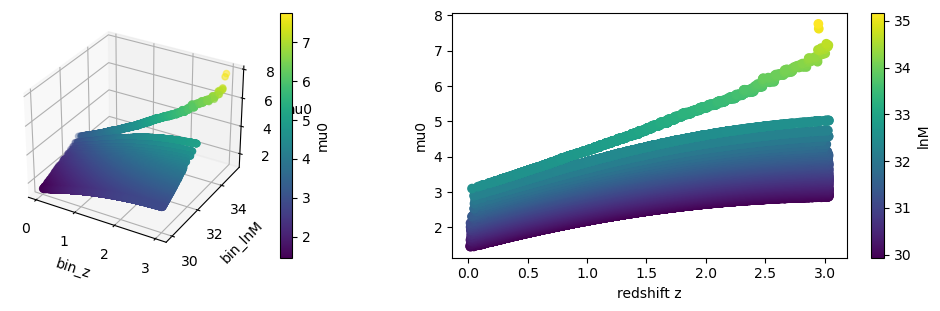

In [9]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(2,2,1, projection='3d')
ax2 = fig.add_subplot(2,2,2)

xs = z_sigma_cut_extended
ys = lnM_sigma_cut_extended
zs = lnR_mean_extended

p1=ax1.scatter(xs, ys, zs, c=zs)

ax1.set_xlabel('bin_z')
ax1.set_ylabel('bin_lnM')
ax1.set_zlabel('mu0')

fig.colorbar(p1, ax=ax1, label='mu0')

p2=ax2.scatter(z_sigma_cut_extended, lnR_mean_extended, c=lnM_sigma_cut_extended, cmap='viridis') #extended tradicional
ax2.set_xlabel('redshift z')
ax2.set_ylabel('mu0')

fig.colorbar(p2, ax=ax2, label='lnM')


## Ascaso - <lnR|M,z> = \mu_0 - Binned data

In [ ]:
# Modelo de Ascaso para <lnR|M,z> = \mu_0 e dados binados

mu0_ascaso = [j for i, j, k, l, m, n in fit_results_ascaso if len(j)>0]

mean_z_ascaso = [k for i, j, k, l, m, n in fit_results_ascaso if len(k) > 0]

mean_lnM_ascaso = [l for i, j, k, l, m, n in fit_results_ascaso if len(l) > 0]

mu0 = np.concatenate(mu0_ascaso,  axis=None)
m_z = np.concatenate(mean_z_ascaso,  axis=None)
m_lnM = np.concatenate(mean_lnM_ascaso,  axis=None)

In [ ]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

xs = m_z
ys = m_lnM
zs = mu0

p3 =ax1.scatter(xs, ys, zs, c=zs, cmap='RdYlBu')
ax1.set_xlabel('bin_z')
ax1.set_ylabel('bin_lnM')
#ax1.set_zlabel('mu0')
fig.colorbar(p3, ax=ax1, label='mu0')

p4 = ax2.scatter(m_lnM, mu0 , c= m_z, cmap='RdYlBu')
ax2.set_xlabel('lnM')
ax2.set_ylabel('mu0')
fig.colorbar(p4, ax=ax2, label='redshift z')

p5 = ax3.scatter(m_z, mu0 , c=m_lnM, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax3.set_xlabel('redshift z')
ax3.set_ylabel('mu0')
fig.colorbar(p5, ax=ax3, label='lnM')

plt.show()

## Extended z2 model - Binned data

In [ ]:
fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

mean_ext_z2 = np.concatenate([j for i, j, k, l, m, n in fit_results_ext if len(j)>0], axis=None)
z_ext_z2 = np.concatenate([k for i, j, k, l, m, n in fit_results_ext if len(k) > 0], axis=None)
lnM_ext_z2 = np.concatenate([l for i, j, k, l, m, n in fit_results_ext if len(l) > 0], axis=None)


p3 =ax1.scatter(z_ext_z2, lnM_ext_z2, mean_ext_z2, c = mean_ext_z2, cmap='plasma', alpha=1.0)
ax1.set_xlabel('z')
ax1.set_ylabel('lnM')
#ax1.set_zlabel('lnR_mean')
fig.colorbar(p3, ax=ax1, label=' <lnR|M,z>')

p4 = ax2.scatter(z_ext_z2, mean_ext_z2 , c=lnM_ext_z2, cmap='plasma')
ax2.set_xlabel('z')
ax2.set_ylabel('<lnR|M,z>')
fig.colorbar(p4, ax=ax2, label='lnM')

p5 = ax3.scatter(lnM_ext_z2, mean_ext_z2 , c=z_ext_z2, cmap='plasma') 
ax3.set_xlabel('lnM')
ax3.set_ylabel('<lnR|M,z>')
fig.colorbar(p5, ax=ax3, label='redshift z')

plt.show()

## Models comparison

In [ ]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.scatter(z_ext_z2, mean_ext_z2, c='k') #Ext z2
p6 = ax1.scatter(m_z, mu0 , c=m_lnM, cmap='RdYlBu') #Ascaso <lnR|M,z> = \mu_0, dados binados
ax1.set_xlabel('z')
ax1.set_ylabel('<lnR|M,z>')
ax1.set_title('Binned Ascaso')
fig.colorbar(p6, ax=ax1, label='lnM')

p7 = ax2.scatter(z_ext_z2, mean_ext_z2, c=lnM_ext_z2, cmap='viridis')
ax2.set_xlabel('z')
ax2.set_ylabel('<lnR|M,z>')
ax2.set_title('Unbinned Ascaso')
fig.colorbar(p7, ax=ax2, label='lnM')

plt.show()